In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
torch.cuda.is_available()

False

In [3]:
# build the dataset
words = open('names.txt', 'r').read().splitlines()
block_size = 3 # context length: how many characters do we take to predict the next one?
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)
def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append


  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27
torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [4]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch


class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x): # when you call Linear Layer it returns Weights @ X + Bias
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]


class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []


# The above 2 classes can be directly from Pytorch Libraries

```Python
import torch
import torch.nn as nn

# Linear layer
linear = nn.Linear(in_features=fan_in, out_features=fan_out, bias=True)

# Batch Normalization
bn = nn.BatchNorm1d(num_features=dim, eps=1e-5, momentum=0.1)

# Tanh activation
tanh = nn.Tanh()
```



In [9]:
vocab_size

27

In [16]:
import torch
import torch.nn as nn


#---------------------------------------------------------
# Input Params
#---------------------------------------------------------
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd),            generator=g)

#---------------------------------------------------------
# Model Architecture
##---------------------------------------------------------
layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(), # First layer
  Linear(           n_hidden, n_hidden), Tanh(), # Hidden Layer
   Linear(           n_hidden, n_hidden), Tanh(), # Hidden Layer
   Linear(           n_hidden, n_hidden), Tanh(), # Hidden Layer
  Linear(           n_hidden, n_hidden), Tanh(), # Hidden Layer
   Linear(           n_hidden, vocab_size),  # Final layer/ Output layer vocab_size = 27
]


#---------------------------------------------------------
# Weight Initialization
#---------------------------------------------------------
with torch.no_grad():
  # last layer: make less confident
  # Last layer weights are scaled down → predictions start “softer” (not overconfident).
  layers[-1].weight *= 0.1

  # all other layers: apply gain
  # Other layers are scaled up with 5/3 (a known trick for tanh activations to improve gradient flow).
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1

#---------------------------------------------------------
# Collecting Parameters
#---------------------------------------------------------
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

46497


In [17]:
#---------------------------------------------------------
# same optimization as last time
#---------------------------------------------------------

max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  #---------------------------------------------------------
  # minibatch construct
  #---------------------------------------------------------
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  #---------------------------------------------------------
  # forward pass
  #---------------------------------------------------------
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  #---------------------------------------------------------
  # backward pass
  #---------------------------------------------------------
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  #---------------------------------------------------------
  # update
  #---------------------------------------------------------
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  #---------------------------------------------------------
  # track stats
  #---------------------------------------------------------
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2988


## Activation in forward pass

layer 1 (      Tanh): mean -0.04, std 0.64, saturated: 5.19%
layer 3 (      Tanh): mean -0.01, std 0.54, saturated: 0.41%
layer 5 (      Tanh): mean +0.01, std 0.53, saturated: 0.47%
layer 7 (      Tanh): mean -0.02, std 0.53, saturated: 0.28%
layer 9 (      Tanh): mean +0.01, std 0.54, saturated: 0.25%


Text(0.5, 1.0, 'activation distribution')

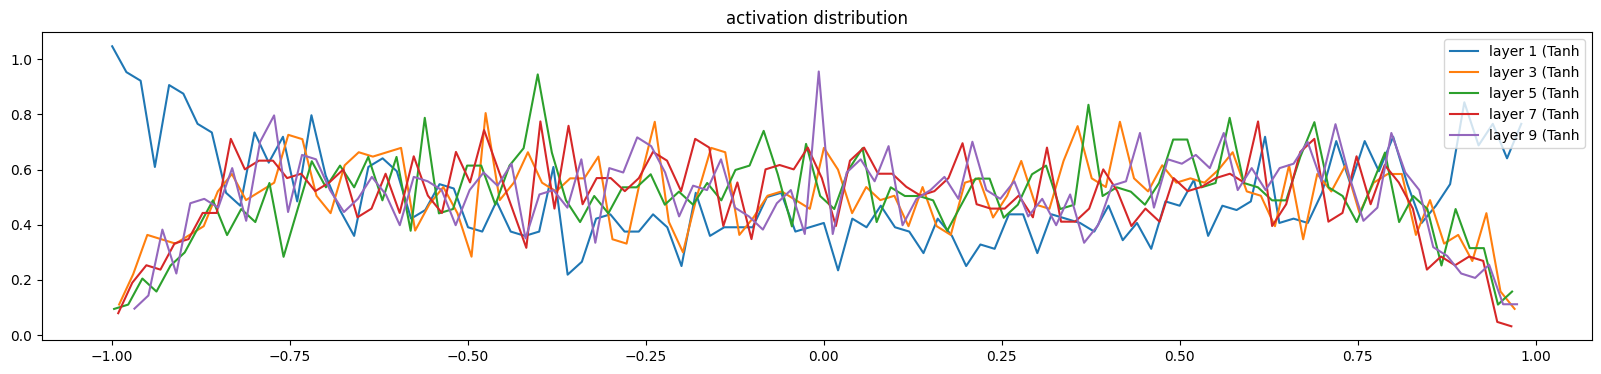

In [18]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

In [19]:
##  We Noticed the intial optimization has gone up so we will reduice the intial weigths


In [36]:
import torch
import torch.nn as nn


#---------------------------------------------------------
# Input Params
#---------------------------------------------------------
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd),            generator=g)

#---------------------------------------------------------
# Model Architecture
##---------------------------------------------------------
layers = [
  Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(), # First layer
  Linear(           n_hidden, n_hidden),  BatchNorm1d(n_hidden),Tanh(), # Hidden Layer
   Linear(           n_hidden, n_hidden),  BatchNorm1d(n_hidden),Tanh(), # Hidden Layer
   Linear(           n_hidden, n_hidden),  BatchNorm1d(n_hidden),Tanh(), # Hidden Layer
  Linear(           n_hidden, n_hidden),  BatchNorm1d(n_hidden),Tanh(), # Hidden Layer
   Linear(           n_hidden, vocab_size, BatchNorm1d(vocab_size)),  # Final layer/ Output layer vocab_size = 27
]


#---------------------------------------------------------
# Weight Initialization
#---------------------------------------------------------
with torch.no_grad():
  # last layer: make less confident
  # Last layer weights are scaled down → predictions start “softer” (not overconfident).
  layers[-1].weight *= 0.1

  # all other layers: apply gain
  # Other layers are scaled up with 5/3 (a known trick for tanh activations to improve gradient flow).
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

#---------------------------------------------------------
# Collecting Parameters
#---------------------------------------------------------
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True


#---------------------------------------------------------
# same optimization as last time
#---------------------------------------------------------

max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  #---------------------------------------------------------
  # minibatch construct
  #---------------------------------------------------------
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  #---------------------------------------------------------
  # forward pass
  #---------------------------------------------------------
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  #---------------------------------------------------------
  # backward pass
  #---------------------------------------------------------
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  #---------------------------------------------------------
  # update
  #---------------------------------------------------------
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  #---------------------------------------------------------
  # track stats
  #---------------------------------------------------------
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization


47497
      0/ 200000: 3.2869


##  Activation in Forward pass

layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.88%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.44%
layer 8 (      Tanh): mean -0.01, std 0.64, saturated: 2.28%
layer 11 (      Tanh): mean +0.00, std 0.64, saturated: 2.25%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 2.12%


Text(0.5, 1.0, 'activation distribution')

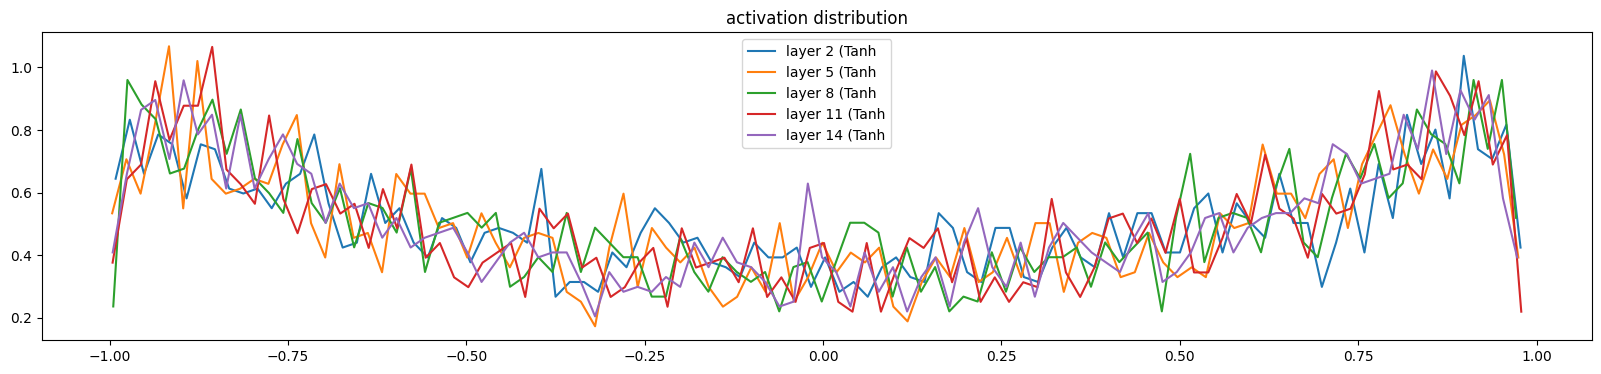

In [37]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

# Activation in reverse pass

layer 2 (      Tanh): mean +0.000000, std 3.722006e-03
layer 5 (      Tanh): mean -0.000000, std 3.188131e-03
layer 8 (      Tanh): mean -0.000000, std 2.911042e-03
layer 11 (      Tanh): mean +0.000000, std 2.574725e-03
layer 14 (      Tanh): mean +0.000004, std 2.095988e-03


Text(0.5, 1.0, 'gradient distribution')

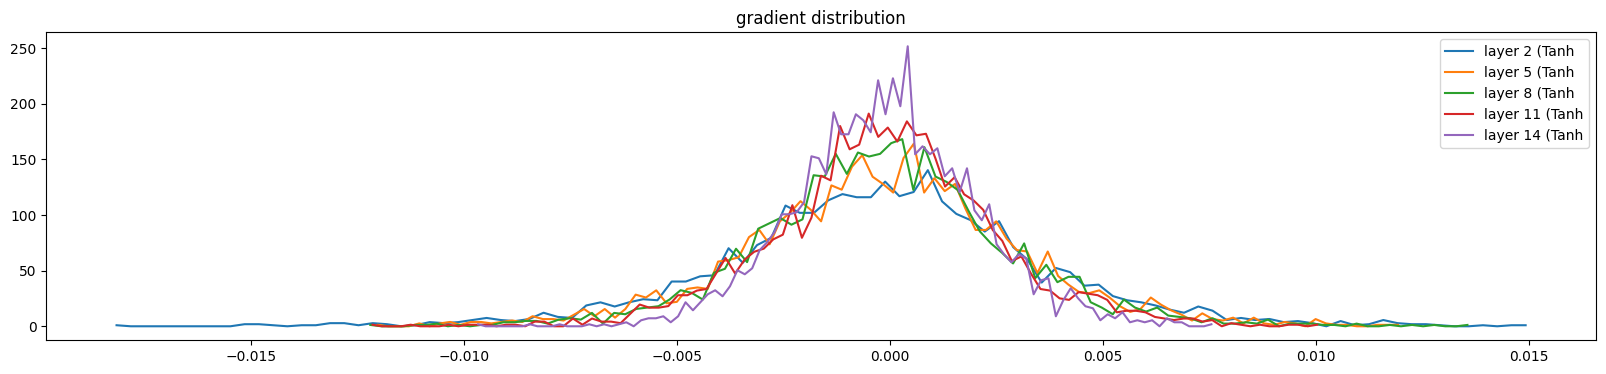

In [38]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 9.953357e-03 | grad:data ratio 9.941165e-03
weight  (30, 100) | mean -0.000060 | std 8.133633e-03 | grad:data ratio 2.598560e-02
weight (100, 100) | mean -0.000090 | std 6.771774e-03 | grad:data ratio 4.037309e-02
weight (100, 100) | mean -0.000030 | std 6.025953e-03 | grad:data ratio 3.566697e-02
weight (100, 100) | mean -0.000003 | std 5.615910e-03 | grad:data ratio 3.343027e-02
weight (100, 100) | mean +0.000004 | std 4.467470e-03 | grad:data ratio 2.662125e-02
weight  (100, 27) | mean +0.000000 | std 1.932995e-02 | grad:data ratio 3.041833e-01


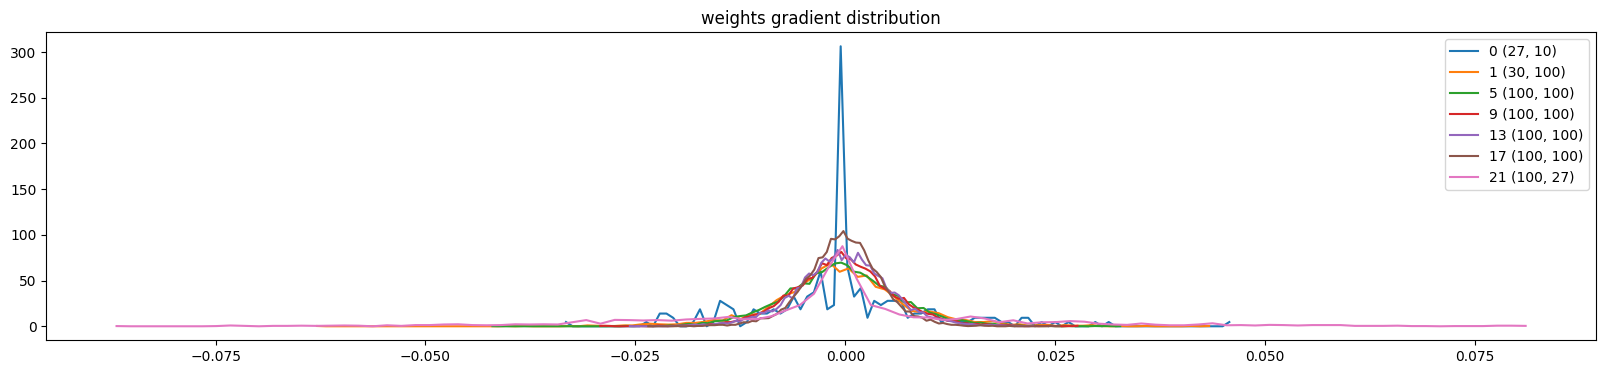

In [39]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

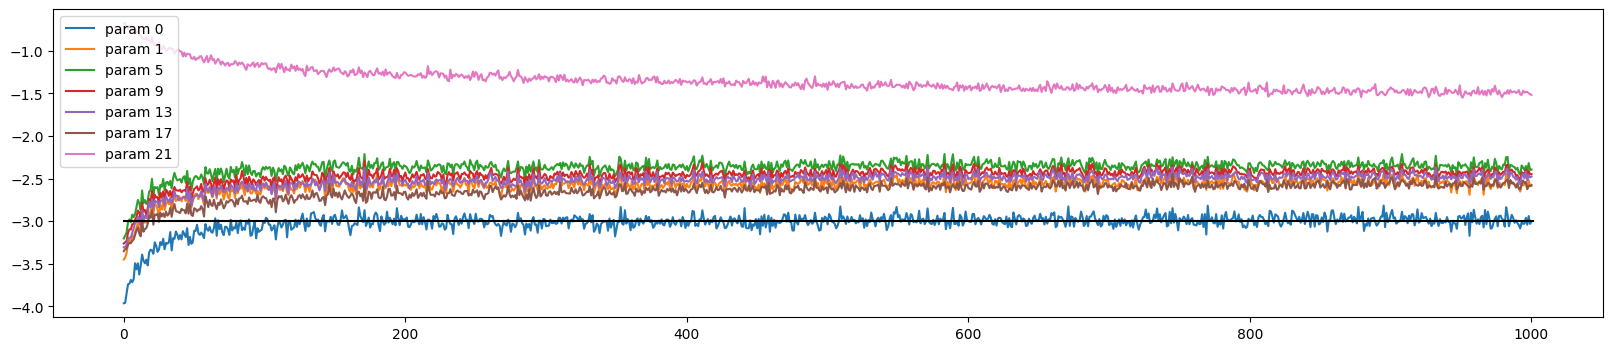

In [40]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [41]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.388735055923462
val 2.3870997428894043


In [42]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

mriah.
myazliee.
madhe.
allee.
mastengrlee.
azleedoeliileli.
jen.
eden.
vananareelyn.
malara.
noshdrergxhiriest.
jahreelyn.
xrtenorou.
zayvde.
jyreli.
elgylle.
mistonda.
hilina.
yarsuh.
zarhlee.


- Model takes sequences of characters.

- Embeds them into vectors.

- Passes through multiple hidden layers.

- Predicts the next character (classification problem).

- Loss tells how wrong it is.

- Gradients flow back, weights adjust, model learns patterns.